# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  

### Dataset source location and context description

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Dataset details 
This marketing dataset is related to 17 marketing campaigns that occurred between May 2008 and November 2010, run by a Portuguese bank that used its own contact-center to do directed marketing campaigns for a long-term deposit application with good interest rates.

In [4]:
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler, NearMiss, EditedNearestNeighbours

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc

from warnings import filterwarnings 
filterwarnings('ignore')

notebook_start_time = time.time()

In [5]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

## 1. Exploratory Data Analysis (EDA)

In [7]:
# Exploring the dataset
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
16890,32,technician,single,university.degree,no,yes,no,telephone,jul,thu,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
8202,30,blue-collar,single,basic.4y,unknown,yes,no,telephone,jun,tue,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,no
10307,53,entrepreneur,married,basic.4y,no,no,no,telephone,jun,mon,...,2,999,0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,no
22603,48,admin.,single,university.degree,no,unknown,unknown,cellular,aug,fri,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no
38785,56,blue-collar,divorced,basic.4y,no,no,no,cellular,nov,thu,...,1,999,0,nonexistent,-3.4,92.649,-30.1,0.714,5017.5,yes


### 1.1 Cleaning up duplicates and missing data

In [9]:
# Checking for missing values and duplicates
print("="*50)
print(f'Data frame shape is: {df.shape}')
total_missing_values = df.isna().sum().sum()
total_duplicates = df.duplicated().sum()
print("="*50)
print(f'Total number of missing values is:{total_missing_values}')
print(f'Total duplicates value is:{total_duplicates}')
print("="*50)

# Dropping duplicates
print(f'Total duplicates removed:{total_duplicates}')
df = df.drop_duplicates().copy()
print(f'Data frame shape is: {df.shape}')
print("="*50)

Data frame shape is: (41188, 21)
Total number of missing values is:0
Total duplicates value is:12
Total duplicates removed:12
Data frame shape is: (41176, 21)


In [10]:
# Exploring datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null  floa

In [11]:
#Changing target column from categorical to numerical
cat_values = df['y'].unique()
print("=" * 65)
print(f'Detected non-numerical values for target column [y]:{cat_values}')
print("=" * 65)
print(f'Replacing non-numerical values for target column [y] ->>>')
df['y'] = df['y'].replace({
    'no': 0,
    'yes': 1,
})
df['y'] = df['y'].astype(int)
num_values = df['y'].unique()
print(f'New unique values for target column [y]: {num_values}')
print("=" * 65)

Detected non-numerical values for target column [y]:['no' 'yes']
Replacing non-numerical values for target column [y] ->>>
New unique values for target column [y]: [0 1]


### 1.2 Exploring and pre-processing categorical features

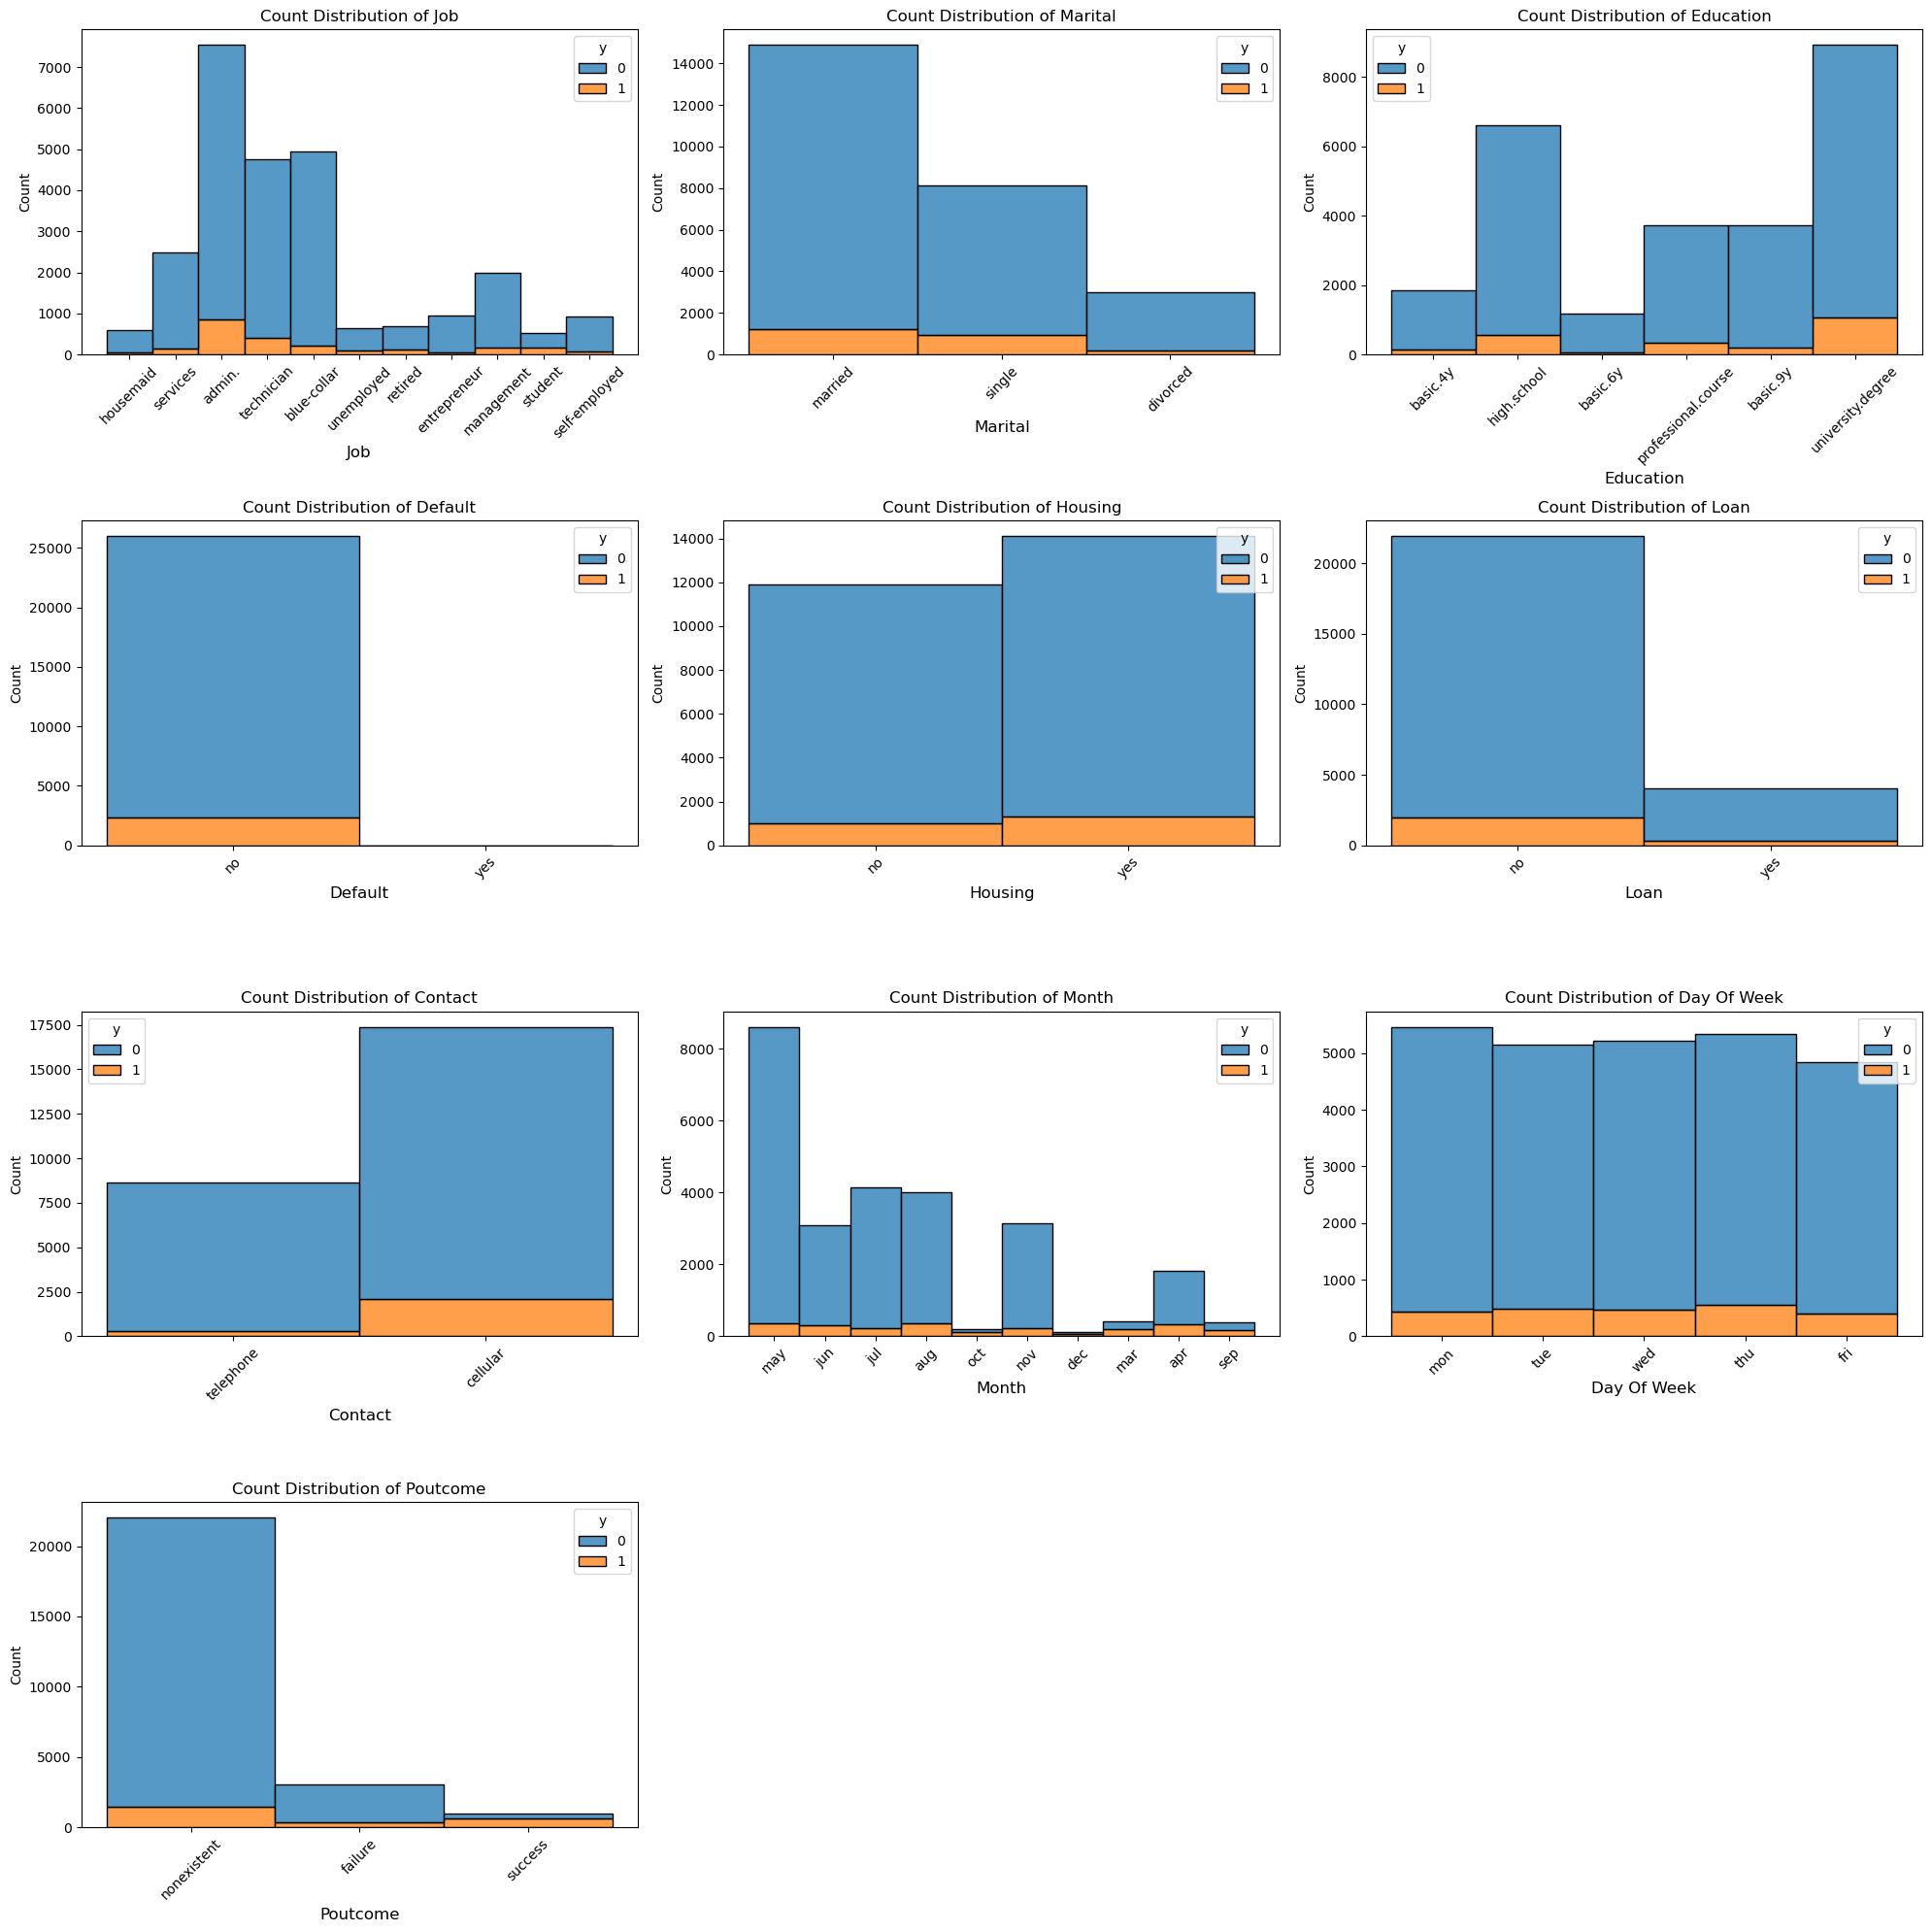

<Figure size 640x480 with 0 Axes>

In [76]:
# Selecting categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Calculating the number of plots needed
num_plots = len(categorical_columns)

# Calculating the number of rows and columns for the subplot grid
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

# Creating the figure and subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the categorical columns and the axes
for i, col in enumerate(categorical_columns):
    sns.histplot(x=col, data=df, ax=axes[i], hue='y', multiple='stack')

    # Set proper titles and labels
    axes[i].set_title(f'Count Distribution of {col.replace("_", " ").title()}', fontsize=12)
    axes[i].set_xlabel(f'{col.replace("_", " ").title()}', fontsize=12)
    axes[i].set_ylabel('Count', fontsize=10)

    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)

# If there are empty subplots, hide them
for j in range(num_plots, len(axes)):
    axes[j].axis('off')

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout()
plt.show();

# Save the plot to a file
plt.savefig("data/categorical_histplots.png");

In [14]:
# Cleaning outliers and unknow values

df = df[df['loan'] != 'unknown']
df = df[df['job'] != 'unknown']
df = df[df['housing'] != 'unknown']
df = df[df['marital'] != 'unknown']
df = df[df['default'] != 'unknown']

# List of values to be removed
values_to_remove = ['illiterate', 'unknown']

# Filter the DataFrame
df = df[~df['education'].isin(values_to_remove)] # remove "illiterate" and "unknown" values that are rather outliers that might affect the models 

### 1.3 Exploring and pre-processing numerical features

HEATMAP ANALYSIS: We can observe Multicollinearity between euribor3m, nr.employed, emp.var.rate and cons.price.idx. 
We will keep only euribor3m because is the only one directly impacting the deposit rates and drop the other rest. 
cons.conf.idx also has very low correlation with deposits since is more related to the comsumptions rather than savings. Therefore, it will be droped.


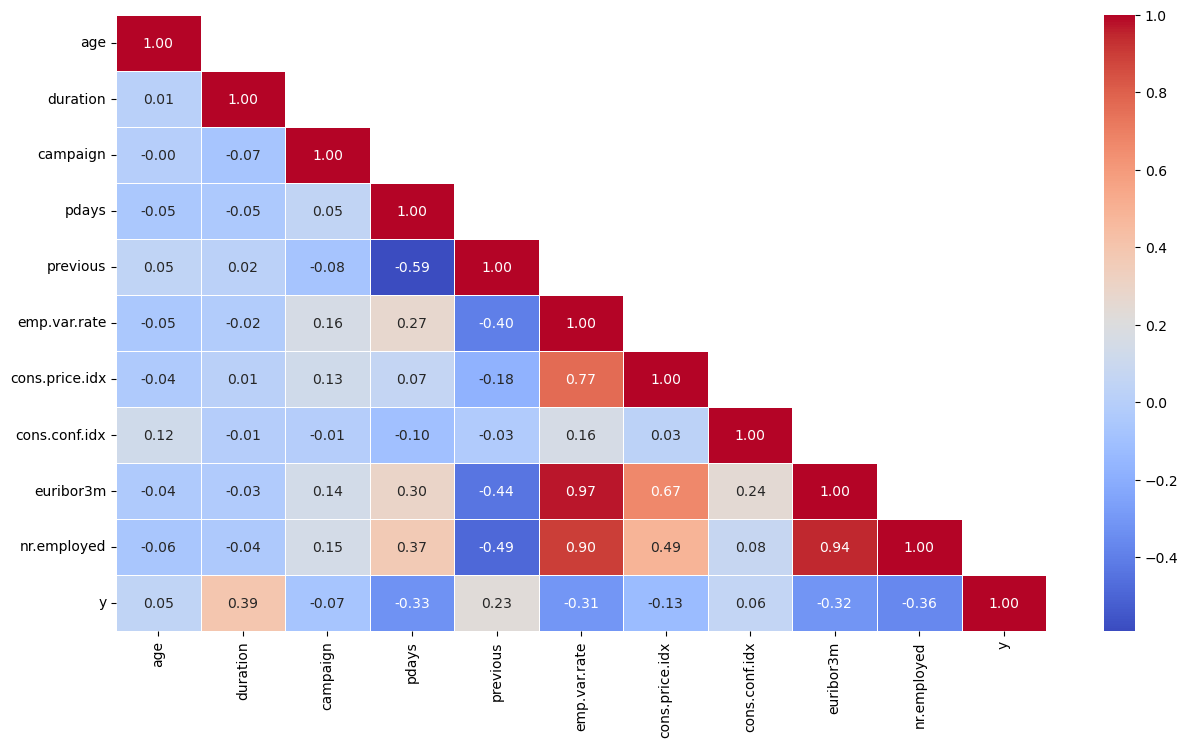

In [16]:
# Numerical features correlation using heatmap
plt.figure(figsize=(15, 8))
mask_matrix = np.ones_like(df.corr(numeric_only=True), dtype=bool)
mask = np.triu(mask_matrix, k=1)
sns.heatmap(df.corr(numeric_only=True), mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

print("="*150)
print("""HEATMAP ANALYSIS: We can observe Multicollinearity between euribor3m, nr.employed, emp.var.rate. 
We will keep only euribor3m because is the only one directly impacting the deposit rates and drop the other rest.""")
print("="*150)
# Save the plot to a file
plt.savefig("data/numerical_heatmap.png");

In [17]:
# Droping feature columns identified above (including duration as per dataset suggestions)
df = df.drop(['nr.employed', 'emp.var.rate'], axis=1)

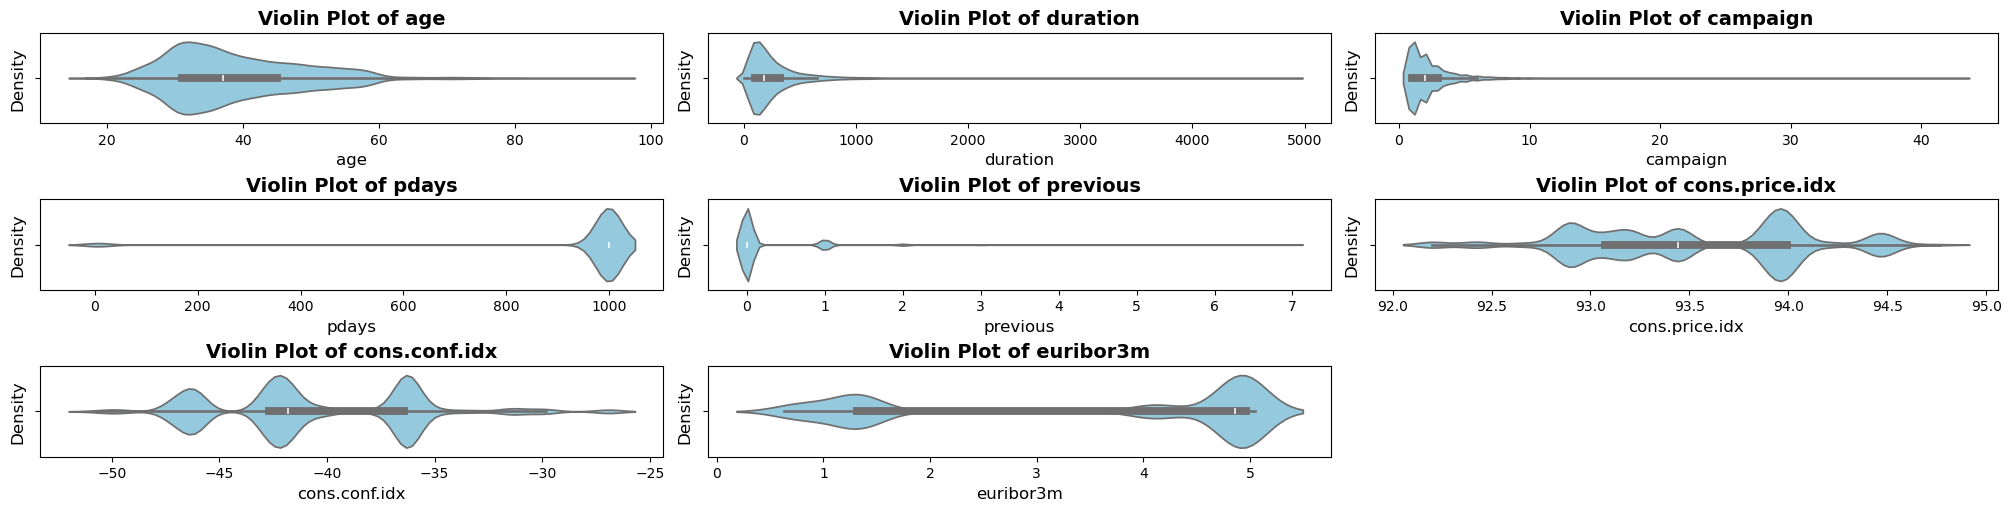

In [18]:
# Select all numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Determine the number of subplots
num_cols = 3  # Number of columns for the grid
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each numerical column and create a violin plot
for i, col in enumerate(numerical_columns):
    sns.violinplot(x=df[col], ax=axes[i], legend=False, color='skyblue')
    axes[i].set_title(f'Violin Plot of {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)

# Hide any unused subplots
for i in range(len(numerical_columns), len(axes)):
    axes[i].axis('off')

# Save the plots to a file
plt.savefig("data/violin_plots.png")

In [19]:
# List of columns to drop or remove outliers from

# Drop columns that do not hold relevant information
df = df.drop(['pdays', 'previous'], axis=1)

columns_to_clean = ['campaign', 'age', 'duration', 'campaign', 'cons.price.idx', 'cons.conf.idx']

# Create a copy of the DataFrame to work on
df_cleaned = df.copy()

print(f"Original number of rows: {len(df)}")
print("=" * 50)

# Loop through each column and remove outliers
for col in columns_to_clean:
    # Calculate Q1, Q3, and IQR
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    initial_rows = len(df_cleaned)
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    rows_removed = initial_rows - len(df_cleaned)

    print(f"Outliers removed from '{col}': {rows_removed} rows")
    print("-" * 50)

print(f"\nTotal rows after cleaning: {len(df_cleaned)}")
print(f"Total outliers removed: {len(df) - len(df_cleaned)}")
print("=" * 50)

# Replace the original DataFrame with the cleaned one
df = df_cleaned.copy()

Original number of rows: 30467
Outliers removed from 'campaign': 1675 rows
--------------------------------------------------
Outliers removed from 'age': 443 rows
--------------------------------------------------
Outliers removed from 'duration': 2031 rows
--------------------------------------------------
Outliers removed from 'campaign': 0 rows
--------------------------------------------------
Outliers removed from 'cons.price.idx': 0 rows
--------------------------------------------------
Outliers removed from 'cons.conf.idx': 312 rows
--------------------------------------------------

Total rows after cleaning: 26006
Total outliers removed: 4461


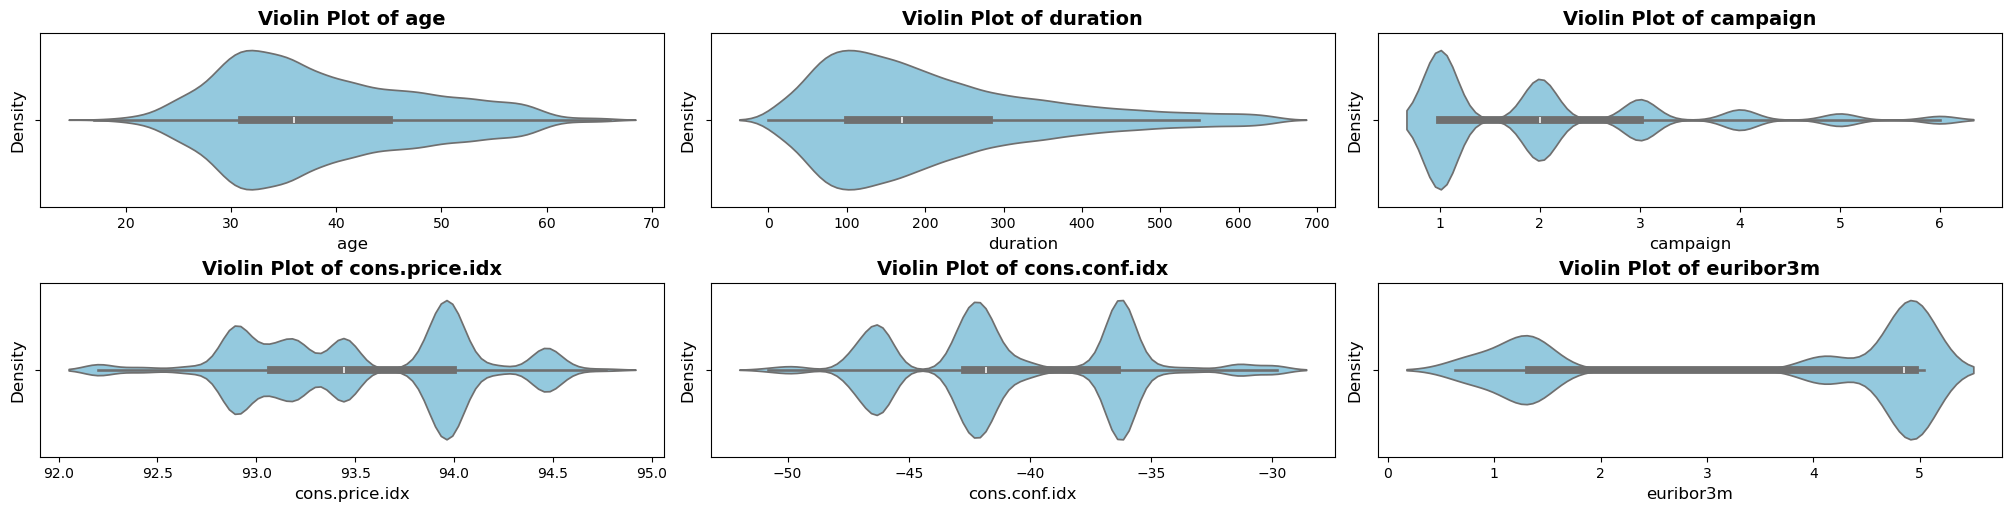

In [20]:
# Select all numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Determine the number of subplots
num_cols = 3  # Number of columns for the grid
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each numerical column and create a violin plot
for i, col in enumerate(numerical_columns):
    sns.violinplot(x=df[col], ax=axes[i], legend=False, color='skyblue')
    axes[i].set_title(f'Violin Plot of {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)

# Hide any unused subplots
for i in range(len(numerical_columns), len(axes)):
    axes[i].axis('off')

# Save the plots to a file
plt.savefig("data/violin_plots.png")

## 2. Pre-Processing and Experimentation Overview
Dataset is very unbalanced and require special treatements to ensure the optimal models results   
I will be using two different experiments that will address data unbalace in two different ways:
- EXPERIMENT A - will use an oversampling technique(SMOTE) to expand the minority class and rebalance the dataset. Models will be trained on the new balanced dataset. Also, in this experiment SVM model will be trained on a smaller sample due to the resource processing requirements that make the overa process very long
- EXPERIMENT B - will use use different undersampling techniques(RandomUnderSampler, NearMiss, EditedNearestNeighbours) to reduce majority class and rebalance the dataset. Models will be trained on the new balanced dataset
- Considering the nature of the unbalanced data I will focus on optimizing the F1-Score rather than Accuracy
- Once the best model is dentifies an additional optimization process will be conducted to select the optimal probability threshold that will be used for the final predictios of each selected model.
- For the best models the parameters will be extracted and the most important features will be listed

### 2.1 Setting the Baseline Model accuracy

In [23]:
# Creating train and target dataframes
X = df.drop('y', axis=1)
y = df['y']

# Splitting data into training and testing sets. I experimented with different test sizes becuase the dataset is big
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Defining the baseline model score
dummy_model = DummyClassifier(strategy='most_frequent')

# I will use cross-validation to get a robust estimate of the baseline performance. I will be using F1-Score since dataset is very unballanced
baseline_score = cross_val_score(dummy_model, X_train, y_train, cv=5, scoring='accuracy')

print("="*65)
print(f"Baseline accuracy set using Majority Class Classifier is: {baseline_score.mean():.4f}")
print("="*65)

Baseline accuracy set using Majority Class Classifier is: 0.9092


### 2.2 Pre-procesing data - Define data pre-processor

In [25]:
# Splitting the data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Defining the preprocessor
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns)
    ],
    remainder='passthrough'
)

# Applying preprocessor and resampler to the training data
# Fitting the preprocessor on the training data and transforming both train and test
preprocessor_fitted = preprocessor.fit(X_train)
X_train_preprocessed = preprocessor_fitted.transform(X_train)
X_test_preprocessed = preprocessor_fitted.transform(X_test)

# Applying the resampler to the preprocessed training data
smote = SMOTE(random_state=42, k_neighbors=5)
X_resampled_a, y_resampled_a = smote.fit_resample(X_train_preprocessed, y_train)

print("="*50)
print(f"Original dataset shape: {X.shape}, {y.shape}")
print(f"Preprocessed training shape: {X_train_preprocessed.shape}, {y_train.shape}")
print(f"Resampled training shape: {X_resampled_a.shape}, {y_resampled_a.shape}")
print(f"Preprocessed testing shape: {X_test_preprocessed.shape}, {y_test.shape}")
print("="*50);

Original dataset shape: (26006, 16), (26006,)
Preprocessed training shape: (20804, 42), (20804,)
Resampled training shape: (37832, 42), (37832,)
Preprocessed testing shape: (5202, 42), (5202,)


### 2.3 Experiment A - Address unbalanced dataset issue using oversampling of the minority class

In [28]:
# Converting resampled data back to a DataFrame
def get_processed_feature_names(preprocessor, X):
    output_features = []
    output_features.extend(preprocessor.named_transformers_['num'].get_feature_names_out())
    output_features.extend(preprocessor.named_transformers_['cat'].get_feature_names_out())
    return output_features
    
processed_feature_names = preprocessor_fitted.get_feature_names_out()

# Convert the sparse matrix to a dense array
X_resampled_a_dense = X_resampled_a.toarray() if hasattr(X_resampled_a, 'toarray') else X_resampled_a
X_test_preprocessed_dense = X_test_preprocessed.toarray() if hasattr(X_test_preprocessed, 'toarray') else X_test_preprocessed

# Creating the DataFrames
X_resampled_a_df = pd.DataFrame(X_resampled_a_dense, columns=processed_feature_names)
X_test_df = pd.DataFrame(X_test_preprocessed_dense, columns=processed_feature_names)

# Defining the models and hyperparameters
best_overall_model_exp_a = None
best_overall_score_exp_a = 0.0
best_overall_params_exp_a = {}
best_model_for_final_eval_exp_a = None

models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000, class_weight='balanced'), {'logisticregression__C': [0.1, 1, 10, 15, 20, 50]}),
    'svc': (SVC(probability=True, class_weight='balanced'), {'svc__C': [10, 15, 20], 'svc__kernel': ['rbf']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(class_weight='balanced'), {'decisiontreeclassifier__max_depth': [5, 10, 12, 13, 14, 15]})
}

results = []
results_optimized = []

# Creating dictionaries to store the predicted probabilities for each experiment
y_pred_probas = {}

for name, (model, params) in models.items():
    # --- Creating the pipeline ---
    pipeline = Pipeline([(name, model)])

    # I will select de best model based on F1-score
    f1_scorer = make_scorer(f1_score)
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring=f1_scorer)
    
    # ... Conditional logic for SVC training  ...
    if name == 'svc':
        print(f"Training SVC on a smaller sample to save time...")
        X_resampled_a_svc, _, y_resampled_a_svc, _ = train_test_split(
            X_resampled_a_df, y_resampled_a, test_size=0.2, random_state=42, stratify=y_resampled_a # Modify the test_size for a faster time
        )
        start_time = time.time()
        grid_search.fit(X_resampled_a_svc, y_resampled_a_svc)
    else:
        print(f"Training {name.upper()} on the full resampled data.")
        start_time = time.time()
        grid_search.fit(X_resampled_a_df, y_resampled_a)
    
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    best_model = grid_search.best_estimator_
    
    # --- Evaluate on preprocessed data ---
    train_score = best_model.score(X_resampled_a_df, y_resampled_a)
    test_score = best_model.score(X_test_df, y_test)
    
    if test_score > best_overall_score_exp_a:
        best_overall_score_exp_a = test_score
        best_overall_model_exp_a = name
        best_overall_params_exp_a = grid_search.best_params_
        best_model_for_final_eval_exp_a = best_model

    y_pred_a = best_model.predict(X_test_df)
    
    # Calculate probabilities and store them in the dictionary for the ROC curve
    y_pred_proba_a = best_model.predict_proba(X_test_df)[:, 1]   # Get the probabilities for the positive class
    y_pred_probas[name] = y_pred_proba_a

    # Calculating metrics using the current predictions
    accuracy = accuracy_score(y_test, y_pred_a)
    recall = recall_score(y_test, y_pred_a)
    precision = precision_score(y_test, y_pred_a, zero_division=0)
    f1 = f1_score(y_test, y_pred_a, zero_division=0)

    # --- Getting Optimal Threshold ---
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_a)
    # Calculate F1-score for each threshold
    f_scores = [f1_score(y_test, (y_pred_proba_a >= t).astype(int)) for t in thresholds]

    # Finding the threshold that gives the highest F1-score
    optimal_threshold = thresholds[np.argmax(f_scores)]

    # --- Applying the optimal threshold to get new predictions ---
    y_pred_optimal_a = (y_pred_proba_a >= optimal_threshold).astype(int)

    # --- Calculating metrics with the new predictions ---
    accuracy_optimized = accuracy_score(y_test, y_pred_optimal_a)
    recall_optimized = recall_score(y_test, y_pred_optimal_a)
    precision_optimized = precision_score(y_test, y_pred_optimal_a, zero_division=0)
    f1_optimized = f1_score(y_test, y_pred_optimal_a, zero_division=0)

    results.append([name, train_score, test_score, fit_time, accuracy, recall, precision, f1])
    results_optimized.append([name, train_score, test_score, fit_time, accuracy_optimized, recall_optimized, precision_optimized, f1_optimized])

# Select the probabilities of the best model for the ROC curve
y_pred_probas_exp_a = y_pred_probas[best_overall_model_exp_a]

# Creating the results DataFrame with the new columns
results_df = pd.DataFrame(results, columns=['model', 'train score', 'test score', 'average fit time', 'accuracy', 'recall', 'precision', 'f1_score'])
results_df.set_index('model', inplace=True)

# Creating the results DataFrame optimized with the new columns
results_df_opt = pd.DataFrame(results_optimized, columns=['model', 'train score', 'test score', 'average fit time', 'accuracy', 
                                                          'recall', 'precision', 'f1_score'])
results_df_opt.set_index('model', inplace=True)

# Saving the df for the final analysis
results_df_exp_a = results_df
results_df_exp_a_opt = results_df_opt

print("="*90)
print("F1-Score Non-Optimized Models results")
print("="*90)

# Beautifying the DataFrame
styled_df_exp_a = (results_df_exp_a.style
    .background_gradient(cmap='Blues')
    .format({
        'train score': '{:.2%}',
        'test score': '{:.2%}',
        'accuracy': '{:.2%}',
        'recall': '{:.2%}',
        'precision': '{:.2%}',
        'f1_score': '{:.2%}',
        'average fit time': '{:.2f}s'
    })
    .highlight_max(subset=['test score', 'accuracy', 'recall', 'precision', 'f1_score'], axis=0, color='green') # Highlight the best scores
    .set_caption("Model Performance Metrics")
)

display(styled_df_exp_a)

print("="*90)
print("F1-Score Optimized Models results")
print("="*90)


# Beautifying the DataFrame
styled_df_exp_a_opt = (results_df_exp_a_opt.style
    .background_gradient(cmap='Blues')
    .format({
        'train score': '{:.2%}',
        'test score': '{:.2%}',
        'accuracy': '{:.2%}',
        'recall': '{:.2%}',
        'precision': '{:.2%}',
        'f1_score': '{:.2%}',
        'average fit time': '{:.2f}s'
    })
    .highlight_max(subset=['test score', 'accuracy', 'recall', 'precision', 'f1_score'], axis=0, color='green') # Highlight the best scores
    .set_caption("Model Performance Metrics")
)

display(styled_df_exp_a_opt)

# Print the overall best model and its parameters
print("="*90)
print("Overall Best Model and Parameters using F1-Score criteria (non-optimized)")
print("="*90)
print(f"Best Model: {best_overall_model_exp_a}")
print(f"Best Test Score: {best_overall_score_exp_a:.2%}")
print(f"Best Parameters: {best_overall_params_exp_a}")
print("="*90)

Training KNN on the full resampled data.
Training LOGISTICREGRESSION on the full resampled data.
Training SVC on a smaller sample to save time...
Training DECISIONTREECLASSIFIER on the full resampled data.
F1-Score Non-Optimized Models results


,train score,test score,average fit time,accuracy,recall,precision,f1_score
model,,,,,,,
knn,96.41%,86.22%,6.06s,86.22%,75.21%,37.17%,49.75%
logisticregression,88.23%,85.66%,0.44s,85.66%,88.77%,37.68%,52.90%
svc,98.28%,90.25%,321.16s,90.25%,57.84%,46.99%,51.85%
decisiontreeclassifier,97.90%,90.00%,1.01s,90.00%,65.47%,46.40%,54.31%


F1-Score Optimized Models results


,train score,test score,average fit time,accuracy,recall,precision,f1_score
model,,,,,,,
knn,96.41%,86.22%,6.06s,86.22%,75.21%,37.17%,49.75%
logisticregression,88.23%,85.66%,0.44s,90.41%,73.09%,48.12%,58.03%
svc,98.28%,90.25%,321.16s,89.39%,66.53%,44.35%,53.22%
decisiontreeclassifier,97.90%,90.00%,1.01s,89.89%,69.07%,46.18%,55.35%


Overall Best Model and Parameters using F1-Score criteria (non-optimized)
Best Model: svc
Best Test Score: 90.25%
Best Parameters: {'svc__C': 20, 'svc__kernel': 'rbf'}


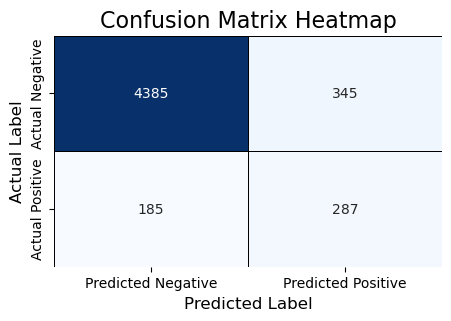

,precision,recall,f1-score,support
0,95.95%,92.71%,94.30%,4730
1,45.41%,60.81%,51.99%,472
accuracy,89.81%,89.81%,89.81%,1
macro avg,70.68%,76.76%,73.15%,5202
weighted avg,91.37%,89.81%,90.46%,5202


In [29]:
# Defining confusion matrix with optimal threshold
y_pred_proba_best_exp_a = best_model_for_final_eval_exp_a.predict_proba(X_test_df)[:, 1]
optimal_threshold_a = optimal_threshold

y_pred_best_exp_a_optimized = (y_pred_proba_best_exp_a >= optimal_threshold_a).astype(int)
cm_a_optimized = confusion_matrix(y_test, y_pred_best_exp_a_optimized)

# Creating DataFrame for the confusion matrix with proper labels
cm_a_df = pd.DataFrame(cm_a_optimized,
                     index=['Actual Negative', 'Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])

# Creating a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(cm_a_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
plt.title('Confusion Matrix Heatmap', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# Getting the classification report as a dictionary
report_dict = classification_report(y_test, y_pred_best_exp_a_optimized, output_dict=True)

# Converting the dictionary to a DataFrame
report_exp_a_df = pd.DataFrame(report_dict).transpose()

# Formating the numerical values as percentages and add a background color
styled_report_exp_a = (report_exp_a_df.style
    .format({'precision': '{:.2%}',
             'recall': '{:.2%}',
             'f1-score': '{:.2%}',
             'support': '{:.0f}'})
    .background_gradient(cmap='Blues', subset=['precision', 'recall', 'f1-score'])
    .set_caption("Classification Report")
)

# Displaying the styled DataFrame
display(styled_report_exp_a)

### 2.4 Experiment B - Address unbalanced dataset issue using Random Undersampling

In [31]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("="*50)
# Checking class distribution of the training data before undersampling
print("Class distribution before undersampling:")
print(Counter(y_train))
print("="*50)

# Creating an undersampling object
rus = RandomUnderSampler(random_state=42)

# Fitting and applying the undersampler to the training data
X_resampled_b, y_resampled_b = rus.fit_resample(X_train, y_train)

print("="*50)
# Checking the class distribution after undersampling
print("Class distribution after undersampling:")
print(Counter(y_resampled_b))
print("="*50)

Class distribution before undersampling:
Counter({0: 18916, 1: 1888})
Class distribution after undersampling:
Counter({0: 1888, 1: 1888})


In [32]:
# Defining and fitting the preprocessor on training data
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns)
    ],
    remainder='passthrough'
)
preprocessor_fitted = preprocessor.fit(X_train)

# Preprocessing training data to be used by the resamplers
X_train_preprocessed = preprocessor_fitted.transform(X_train)

print("="*50)
print("Class distribution before undersampling:")
print(Counter(y_train))
print("="*50)

# Defining a dictionary of undersampling techniques
undersamplers = {
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    #'NearMiss': NearMiss(version=1, n_neighbors=3),
    #'EditedNearestNeighbours': EditedNearestNeighbours(n_neighbors=3)
}

# Looping through each undersampler and apply it to the preprocessed data
for name, resampler in undersamplers.items():
    print(f"Applying {name}...")
    
    # Fitting and applying the undersampler to the preprocessed training data
    X_resampled, y_resampled = resampler.fit_resample(X_train_preprocessed, y_train)

    print("="*50)
    # Checking the class distribution after undersampling
    print(f"Class distribution after {name}:")
    print(Counter(y_resampled))
    print("="*50)

Class distribution before undersampling:
Counter({0: 18916, 1: 1888})
Applying RandomUnderSampler...
Class distribution after RandomUnderSampler:
Counter({0: 1888, 1: 1888})


In [33]:
# Defining the models and hyperparameters

best_overall_model_exp_b = None
best_overall_score_exp_b = 0.0
best_overall_params_exp_b = {}
best_model_for_final_eval_exp_b = None

models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000, class_weight='balanced'), {'logisticregression__C': [0.1, 1, 10, 50]}),
    'svc': (SVC(probability=True, class_weight='balanced'), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(class_weight='balanced'), {'decisiontreeclassifier__max_depth': [5, 10, 12, 15]})
}

results = []
results_optimized = []

# Creating dictionaries to store the predicted probabilities for each experiment
y_pred_probas = {}

# Function to get feature names after preprocessing
def get_feature_names(preprocessor, X):
    output_features = []
    
    # Check if preprocessor has 'num' and 'cat' named transformers
    if 'num' in preprocessor.named_transformers_:
        output_features.extend(preprocessor.named_transformers_['num'].get_feature_names_out())
    
    if 'cat' in preprocessor.named_transformers_:
        output_features.extend(preprocessor.named_transformers_['cat'].get_feature_names_out())
        
    return output_features

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])

    # I will select de best model based on F1-score
    f1_scorer = make_scorer(f1_score)
    
    # Performing grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring=f1_scorer)
    
    # Fitting the model and time it
    start_time = time.time()
    grid_search.fit(X_resampled_b, y_resampled_b)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Getting the best estimator
    best_model = grid_search.best_estimator_
    
    # Evaluating on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)

    # Checking if the current model is the best overall
    if test_score > best_overall_score_exp_b:
        best_overall_score_exp_b = test_score
        best_overall_model_exp_b = name
        best_overall_params_exp_b = grid_search.best_params_
        best_model_for_final_eval_exp_b = best_model

    # Making predictions and calculate metrics for current model
    y_pred_b = best_model.predict(X_test)
       
    # Calculating probabilities and store them in the dictionary for the ROC curve
    y_pred_proba_b = best_model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
    y_pred_probas[name] = y_pred_proba_b

    accuracy = accuracy_score(y_test, y_pred_b)
    recall = recall_score(y_test, y_pred_b)
    precision = precision_score(y_test, y_pred_b, zero_division=0)
    f1 = f1_score(y_test, y_pred_b, zero_division=0)

    # Getting Optimal Threshold
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_b)
    distance_to_corner = np.sqrt(fpr**2 + (1 - tpr)**2)
    optimal_threshold_index = np.argmin(distance_to_corner)
    optimal_threshold = thresholds[optimal_threshold_index]

    # Applying the optimal threshold to get new predictions
    y_pred_optimal_b = (y_pred_proba_b >= optimal_threshold).astype(int)

    # Calculating metrics with the new predictions
    accuracy_optimized = accuracy_score(y_test, y_pred_optimal_b)
    recall_optimized = recall_score(y_test, y_pred_optimal_b)
    precision_optimized = precision_score(y_test, y_pred_optimal_b, zero_division=0)
    f1_optimized = f1_score(y_test, y_pred_optimal_b, zero_division=0)

    # Getting Features Importance
    print(f"\n--- Feature Importance for {name.upper()} ---")
    
    # Getting the features names
    feature_names = get_feature_names(best_model.named_steps['preprocessor'], X_test)
    
    # Conditional logic for different model types
    if name in ['logisticregression', 'svc']:
        # For linear models, use absolute coefficients
        if hasattr(best_model.named_steps[name], 'coef_'):
            # Checking if coef_ is a sparse matrix and convert it to a dense array
            coef = best_model.named_steps[name].coef_
            if hasattr(coef, 'toarray'):
                importances = np.abs(coef.toarray()[0])
            else:
                importances = np.abs(coef[0])
    
            importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
            
            # Rounding the 'Importance' column to two decimal places
            importance_df['Importance'] = importance_df['Importance'].round(2)
            print(importance_df.sort_values(by='Importance', ascending=False).head(10))
    
    elif name == 'decisiontreeclassifier':
        # For tree-based models, use feature_importances_
        if hasattr(best_model.named_steps[name], 'feature_importances_'):
            importances = best_model.named_steps[name].feature_importances_
            importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

            # Round the 'Importance' column to two decimal places
            importance_df['Importance'] = importance_df['Importance'].round(2)
            print(importance_df.sort_values(by='Importance', ascending=False).head(10))
   
    # Appending the results, including the new metrics for both versions
    results.append([name, train_score, test_score, fit_time, accuracy, recall, precision, f1])
    results_optimized.append([name, train_score, test_score, fit_time, accuracy_optimized, recall_optimized, precision_optimized, f1_optimized])

# Selecting the probabilities of the best model for the ROC curve
y_pred_probas_exp_b = y_pred_probas[best_overall_model_exp_b]

# Creating the results DataFrame with the new columns
results_df = pd.DataFrame(results, columns=['model', 'train score', 'test score', 'average fit time', 'accuracy', 'recall', 'precision', 'f1_score'])
results_df.set_index('model', inplace=True)

# Creating the results DataFrame optimized with the new columns
results_df_opt = pd.DataFrame(results_optimized, columns=['model', 'train score', 'test score', 'average fit time', 
                                                          'accuracy', 'recall', 'precision', 'f1_score'])
results_df_opt.set_index('model', inplace=True)

# Saving the dfs for the final analysis
results_df_exp_b = results_df
results_df_exp_b_opt = results_df_opt

print("="*90)
print("F1-Score Non-Optimized Models results")
print("="*90)

# Beautifing the DataFrame
styled_df_exp_b = (results_df_exp_b.style
    .background_gradient(cmap='Blues')
    .format({
        'train score': '{:.2%}',
        'test score': '{:.2%}',
        'accuracy': '{:.2%}',
        'recall': '{:.2%}',
        'precision': '{:.2%}',
        'f1_score': '{:.2%}',
        'average fit time': '{:.2f}s'
    })
    .highlight_max(subset=['test score', 'accuracy', 'recall', 'precision', 'f1_score'], axis=0, color='green') # Highlight the best scores
    .set_caption("Model Performance Metrics")
)

display(styled_df_exp_b)

print("="*90)
print("F1-Score Optimized Models results")
print("="*90)


# Beautifing the DataFrame
styled_df_exp_b_opt = (results_df_exp_b_opt.style
    .background_gradient(cmap='Blues')
    .format({
        'train score': '{:.2%}',
        'test score': '{:.2%}',
        'accuracy': '{:.2%}',
        'recall': '{:.2%}',
        'precision': '{:.2%}',
        'f1_score': '{:.2%}',
        'average fit time': '{:.2f}s'
    })
    .highlight_max(subset=['test score', 'accuracy', 'recall', 'precision', 'f1_score'], axis=0, color='green') # Highlight the best scores
    .set_caption("Model Performance Metrics")
)

display(styled_df_exp_b_opt)

# Print the overall best model and its parameters
print("="*90)
print("Overall Best Model and Parameters using F1-Score criteria (non-optimized)")
print("="*90)
print(f"Best Model: {best_overall_model_exp_b}")
print(f"Best Test Score: {best_overall_score_exp_b:.2%}")
print(f"Best Parameters: {best_overall_params_exp_b}")
print("="*90)


--- Feature Importance for KNN ---

--- Feature Importance for LOGISTICREGRESSION ---
                        Feature  Importance
33                    month_oct        4.05
40             poutcome_success        2.08
5                     euribor3m        1.86
30                    month_mar        1.84
1                      duration        1.60
31                    month_may        1.50
10                  job_retired        1.12
22  education_university.degree        1.03
13                  job_student        1.02
39         poutcome_nonexistent        0.82

--- Feature Importance for SVC ---

--- Feature Importance for DECISIONTREECLASSIFIER ---
              Feature  Importance
5           euribor3m        0.55
1            duration        0.29
31          month_may        0.09
33          month_oct        0.04
3      cons.price.idx        0.01
0                 age        0.00
30          month_mar        0.00
24           loan_yes        0.00
25  contact_telephone        0.0

,train score,test score,average fit time,accuracy,recall,precision,f1_score
model,,,,,,,
knn,84.55%,83.28%,0.39s,83.28%,89.19%,33.95%,49.18%
logisticregression,85.86%,85.35%,0.17s,85.35%,88.98%,37.17%,52.43%
svc,84.67%,83.33%,5.37s,83.33%,93.43%,34.53%,50.43%
decisiontreeclassifier,81.89%,80.72%,0.18s,80.72%,92.80%,31.13%,46.62%


F1-Score Optimized Models results


,train score,test score,average fit time,accuracy,recall,precision,f1_score
model,,,,,,,
knn,84.55%,83.28%,0.39s,83.28%,89.19%,33.95%,49.18%
logisticregression,85.86%,85.35%,0.17s,85.33%,89.41%,37.18%,52.52%
svc,84.67%,83.33%,5.37s,85.29%,90.47%,37.23%,52.75%
decisiontreeclassifier,81.89%,80.72%,0.18s,85.01%,84.75%,36.10%,50.63%


Overall Best Model and Parameters using F1-Score criteria (non-optimized)
Best Model: logisticregression
Best Test Score: 85.35%
Best Parameters: {'logisticregression__C': 50}


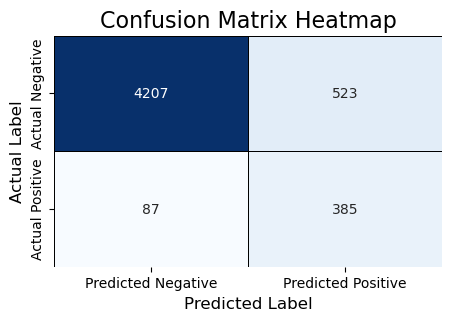

,precision,recall,f1-score,support
0,97.97%,88.94%,93.24%,4730
1,42.40%,81.57%,55.80%,472
accuracy,88.27%,88.27%,88.27%,1
macro avg,70.19%,85.26%,74.52%,5202
weighted avg,92.93%,88.27%,89.84%,5202


In [34]:
# Defining confusion matrix with optimal threshold
y_pred_proba_best_exp_b = best_model_for_final_eval_exp_b.predict_proba(X_test)[:, 1]
optimal_threshold_b = optimal_threshold

y_pred_best_exp_b_optimized = (y_pred_proba_best_exp_b >= optimal_threshold_b).astype(int)
cm_b_optimized = confusion_matrix(y_test, y_pred_best_exp_b_optimized)

# Creating a DataFrame for the confusion matrix with proper labels
cm_b_df = pd.DataFrame(cm_b_optimized,
                     index=['Actual Negative', 'Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])

# Creatings a heatmap for more redability
plt.figure(figsize=(5, 3))
sns.heatmap(cm_b_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
plt.title('Confusion Matrix Heatmap', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# Getting the classification report as a dictionary
report_dict = classification_report(y_test, y_pred_best_exp_b_optimized, output_dict=True)

# Converting the dictionary to a DataFrame
report_exp_b_df = pd.DataFrame(report_dict).transpose()

# Formating the numerical values as percentages and add a background color
styled_report_exp_b = (report_exp_b_df.style
    .format({'precision': '{:.2%}',
             'recall': '{:.2%}',
             'f1-score': '{:.2%}',
             'support': '{:.0f}'})
    .background_gradient(cmap='Blues', subset=['precision', 'recall', 'f1-score'])
    .set_caption("Classification Report")
)

# Display the styled DataFrame
display(styled_report_exp_b)

## 3. Experiments results and comparison

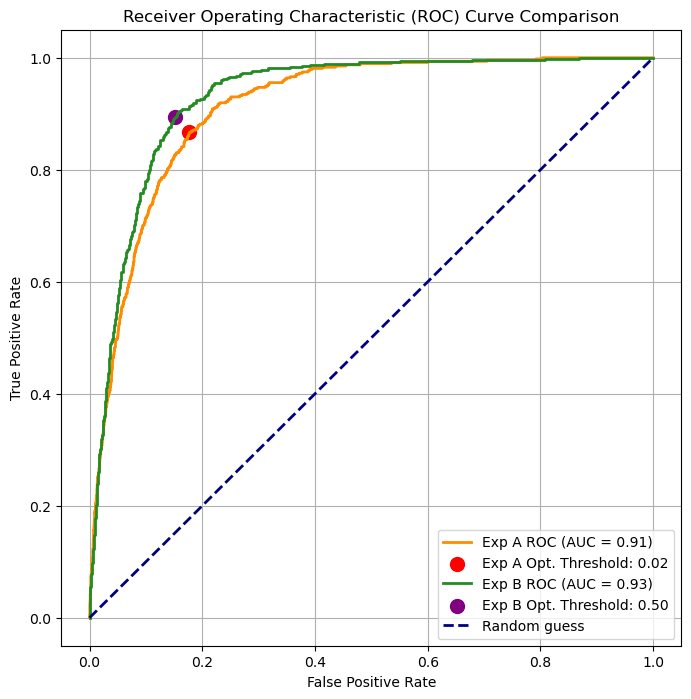

<Figure size 640x480 with 0 Axes>

In [36]:
# --- Calculations for Experiment A ---
fpr_a, tpr_a, thresholds_a = roc_curve(y_test, y_pred_probas_exp_a) # Using the probabilities of the best model for Experiment A
roc_auc_a = roc_auc_score(y_test, y_pred_probas_exp_a)

distance_a = np.sqrt(fpr_a**2 + (1 - tpr_a)**2)
optimal_threshold_index_a = np.argmin(distance_a)
optimal_threshold_a = thresholds_a[optimal_threshold_index_a]

# --- Calculations for Experiment B ---
fpr_b, tpr_b, thresholds_b = roc_curve(y_test, y_pred_probas_exp_b) # Using the probabilities of the best model for Experiment B
roc_auc_b = roc_auc_score(y_test, y_pred_probas_exp_b)

distance_b = np.sqrt(fpr_b**2 + (1 - tpr_b)**2)
optimal_threshold_index_b = np.argmin(distance_b)
optimal_threshold_b = thresholds_b[optimal_threshold_index_b]

# --- Plotting Both ROC Curves and Optimal Thresholds ---
plt.figure(figsize=(8, 8))

# Plot ROC curve for Experiment A
plt.plot(fpr_a, tpr_a, color='darkorange', lw=2, label=f'Exp A ROC (AUC = {roc_auc_a:.2f})')
# Add a marker for the optimal threshold of Experiment A
plt.scatter(
    fpr_a[optimal_threshold_index_a], 
    tpr_a[optimal_threshold_index_a], 
    color='red', 
    marker='o', 
    s=100, 
    label=f'Exp A Opt. Threshold: {optimal_threshold_a:.2f}'
)

# Plot ROC curve for Experiment B
plt.plot(fpr_b, tpr_b, color='forestgreen', lw=2, label=f'Exp B ROC (AUC = {roc_auc_b:.2f})')
# Add a marker for the optimal threshold of Experiment B
plt.scatter(
    fpr_b[optimal_threshold_index_b], 
    tpr_b[optimal_threshold_index_b], 
    color='purple', 
    marker='o', 
    s=100, 
    label=f'Exp B Opt. Threshold: {optimal_threshold_b:.2f}'
)

# Plot the random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')

# Add labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

# Save the plots to a file
plt.savefig("data/ROCs_plot.png");

In [37]:
notebook_end_time = time.time()
notebook_elapsed_time = notebook_end_time - notebook_start_time
print(f"Total Elapsed time : {notebook_elapsed_time/60:.2f} Minutes")

Total Elapsed time : 18.36 Minutes


## 4. Findings and Recommendations

#### Experiments results and key findings

**Overall technical findings**
- For these experiments using accuracy as key evaluation metric is very misleading and not recommended becuae of the very unbalanced data set 90% for the majority class. Considering the business context, identification of bank's clients that would accept a marketing campaing promotion (in this case a good interest rate deposit) the most important evaluation metrics are Precision, Recall and F1-Score overall but even more important in the context of the minority class (which in this case is the accepted promotion). Considering the above the experiments were designed to optimise(increase) F1-Score, which is a better metric for unbalanced dataset because is representing the optimal point between precision and recall metrics.
- Models selection and optimization techniques considered two stages:
   1. Selecting the best model using GridSearch and adjusting the hyperparameters for the best F1-score
   2. Finding the optimal probability threeshold for each model comparing the results for **F1-Score maximization**
- Techniques used to deal with unbalanced nature of the dataset and its size in Experiment A:
   - **Oversampling** using SMOTE
   - **UnderSampling** using: RandomUnderSampler, NearMiss-version1, EditedNearestNeighbours
   - **class_weight='balanced'** for all models where applicable
   - **Adjustable dataset sampling for SVM** which is the most cumputational expenside model (started with smaller test samples to run more kernels and after selecting the best kernel by increased the test sample
- During the experimentation I've concluded that oversampling the minority class created a better dataset than undersampling the majority class. The results are showing that all models performs better on the oversampled dataset. This is clearly observed by comparing the F1-Score, Precision and Recall metrics for both experiments. I have used Confusion Matrix, and Classification Report for a deeper dive into the performance of each model
  - The **best models from Experiment-A and also overall** is: **LogisticRegression Model** with below with below results:

<div align="center">
  <img src="data/Experiment-A_res.png" alt="Experiment-A Results">
</div>
    
  - The best models for Experiment-B is: **Support Vector Machine (SVM)** with below results:

<div align="center">
  <img src="data/Experiment-B_res.png" alt="Experiment-B Results">
</div>
     
  - For each models (where reasonable possible) I've also extracted the most relevant features:
- In both experiments I've managed to get a pretty good ROC score 0.93 for Experiment-B and 0.91 for Experiment-A. Nevertheless, ROC for Experiment-B is slighly better but only because the optimization was performed for F1-Score and not ROC. However ROC, confirms that bots experiments show good good results.
  
<div align="center">
  <img src="data/ROCs_Plot.jpg" alt="ROCs Results">
</div>

- Nest step is to try new more powerfull models to further improve F1-Score

**Business related findings and recommendations:**

With the **selected Logistic Regression model** if the bank intend to launcg a very targets campaing that optimizes the campaing cost then they should be able to **identify a list of clients that should be targeted by the new promotion campaign**. 

The model predict that **45.5% of the clients in this list will accept the promotion!**
This will represent **60.59%** of the total number of all clients in the database that would accept the promotion.
This is explained by below Classification Reports that shown the **Precision** and **Recall** as **%** for the **Class 1 (Clients that would accept the promotion)**:

<div align="center">
  <img src="data/Experiment-A_Confusion&Classification.jpg" alt="Experiment-A Results">
</div>

If the bank is not very concerned with the overall campaign cost and want to maximize the total number of clients that will accept the promotion, then they can use the model to select from bank database all clients that should not be part of the campaing. This will allow the bank to exclude from the campaing the clients that would not take the promotion anyway. This approach will give the bank all clinets that would not accpt the promotion with a probability of **95.95%**. 
In this scenario the bank will have a bigger list of clients than in the first scenario. In this list the percentace of clinets that will accept the promotion is significantly bigger than **45.5%**. In this case the bank would miss only **5%** of the total clients that are in the database but not selected for the marketing campaing.  

#### Next step to improve the results

Nest step is to try new more powerfull models to further improve F1-Score